# Imported accesories

In [75]:
import numpy as np
from vector_class import TripleVector
import matplotlib.pyplot as plt
import random


# Parameters

In [30]:
A0 = 100 # Bq
Ab = 5 # Bq
h = 1 # m
D_t = 10 # the pause on each point od the grid in s
x_max = 4 # m
y_max = 4 # m
#grid

np.linspace(-3, 3, 4)

array([-3., -1.,  1.,  3.])

# Flying over the surface

In [79]:
from tokenize import Triple

def I(A0, r, D_t):
    return (1 / r**2) * A0 * D_t

def point_source(x_max, y_max):
    return [random.uniform(-x_max, x_max),random.uniform(-y_max, y_max)]

def flyOver(A0, Ab, D_t, h, x_max, y_max, square):
    if (x_max/square % 2) != 0 or (y_max/square % 2) != 0:
        return "Error: Not valid grid size or division"
    xes = np.linspace(-x_max + square/2, x_max - square/2, int(2*x_max/square))
    # grid = np.zeros((1, 2))
    source = point_source(x_max, y_max)
    intensities = np.zeros((int(2*(x_max/square)), int(2*(y_max/square))))
    n, m = int(2*(x_max/square)) - 1, 0
    i = 1
    y = -y_max + square/2
    for x in xes:
        while abs(y) <= y_max:
            drone = TripleVector(x, y, h)
            position = TripleVector(source[0], source[1], 0)
            r_vector = drone - position
            r = r_vector.magnitude()
            # print(n)
            # row = np.array((x, y, I(A0, r, D_t)))
            intensities[n, m] = I(A0, r, D_t)
            # print(intensities)
            # grid = np.vstack((grid, np.array((x, y))))
            y += (square)*i

            n -= 1*i
        n += 1*i
        i = i * (-1)
        y += (square)*i
        m += 1

    return [intensities[:, :], source]

# source, A0, Ab, D_t, h, x_max, y_max, square
measurement = flyOver(100, 5, 10, 6, 4, 4, 1) 


## Visualization

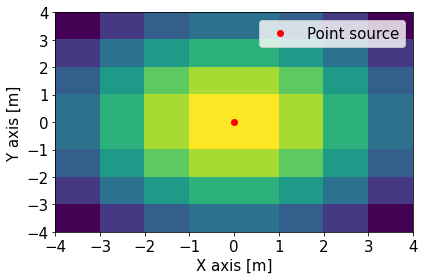

In [74]:
def visualize(measurement, x_max, y_max):
    
    plt.imshow(measurement[0], extent=[-x_max,x_max,-y_max,y_max], aspect="auto")
    # X, Y = measurement[1][0], measurement[1][1]
    plt.plot(X, Y, "o", color = 'r', label = "Point source")

    plt.xlabel("X axis [m]", fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.ylabel("Y axis [m]", fontsize = 15)
    plt.yticks(fontsize = 15)

   
    plt.legend(fontsize = 15)
    #plt.grid()

    plt.tight_layout()
    #plt.savefig("")
    plt.show()

visualize(measurement, x_max, y_max)
